In [94]:
!pip install seaborn

In [95]:
# Install required packages.
import torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive

Looking in links: https://data.pyg.org/whl/torch-2.0.0.post102.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0.post102.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0.post102.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /private/var/folders/rp/ggplbw_d5p97pwq5_00q6jdm0000gn/T/pip-req-build-9725lcv4
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /private/var/folders/rp/ggplbw_d5p97pwq5_00q6jdm0000gn/T/pip-req-build-9725lcv4
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 699120e2584077b0113eb9519e58c5e3dbcc1ec6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [96]:
# import required modules
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

In [97]:
# download the dataset
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
extract_zip(download_url(url, "../data/raw/"), "../data/raw/")

movie_path = "./ml-latest-small/movies.csv"
rating_path = "./ml-latest-small/ratings.csv"

Using existing file ml-latest-small.zip
Extracting ../data/raw/ml-latest-small.zip


In [98]:
movies = pd.read_csv("../data/raw/ml-latest-small/movies.csv")
ratings = pd.read_csv("../data/raw/ml-latest-small/ratings.csv")
tags = pd.read_csv("../data/raw/ml-latest-small/tags.csv")
links = pd.read_csv("../data/raw/ml-latest-small/links.csv")

In [99]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [100]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [101]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [102]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


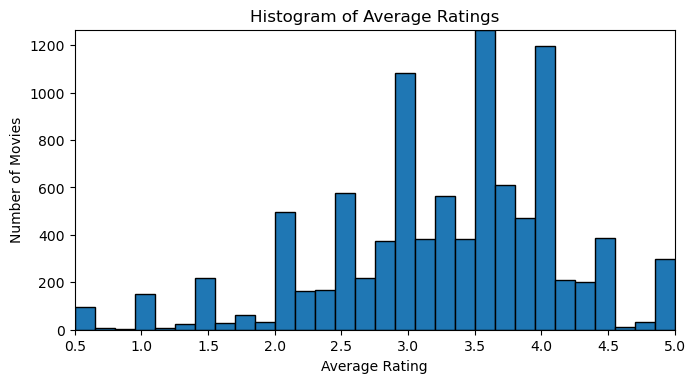

In [103]:
# Assuming you have a DataFrame named 'df' with columns movieid, rating, userid, timestamp
# You can group the data by 'movieid' and calculate the average rating for each movie
average_ratings = ratings.groupby("movieId")["rating"].mean()

# Plot the histogram
plt.figure(figsize=(6, 3))
plt.hist(average_ratings, bins=30, edgecolor="k")
plt.title("Histogram of Average Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Number of Movies")
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig("../reports/assets/average_ratings.png", bbox_inches="tight")

/var/folders/rp/ggplbw_d5p97pwq5_00q6jdm0000gn/T/ipykernel_4793/1349608200.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(average_ratings, shade=True)


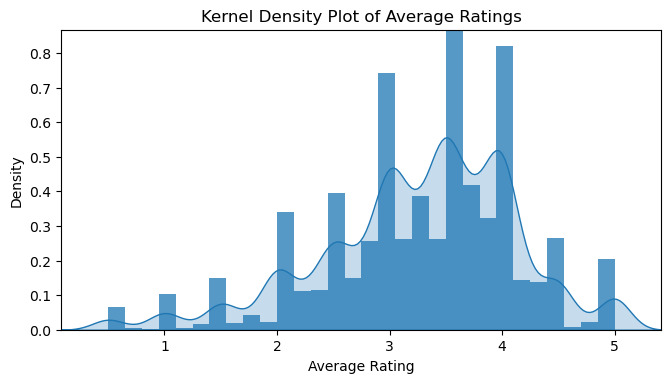

In [104]:
plt.figure(figsize=(6, 3))
plt.hist(average_ratings, bins=30, density=True, alpha=0.75)
sns.kdeplot(average_ratings, shade=True)
plt.title("Kernel Density Plot of Average Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Density")
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig("../reports/assets/average_ratings_pretty.png", bbox_inches="tight")

In [105]:
ratings_backup = ratings.copy()

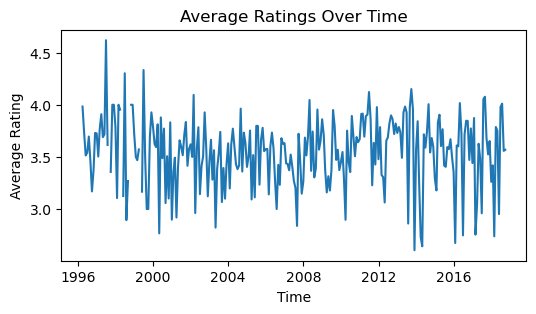

In [106]:
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit="s")
ratings.set_index("timestamp", inplace=True)
average_ratings_over_time = ratings.resample("M")["rating"].mean()

plt.figure(figsize=(6, 3))
plt.plot(average_ratings_over_time.index, average_ratings_over_time.values)
plt.title("Average Ratings Over Time")
plt.xlabel("Time")
plt.ylabel("Average Rating")
plt.show()

In [107]:
ratings = ratings_backup.copy()

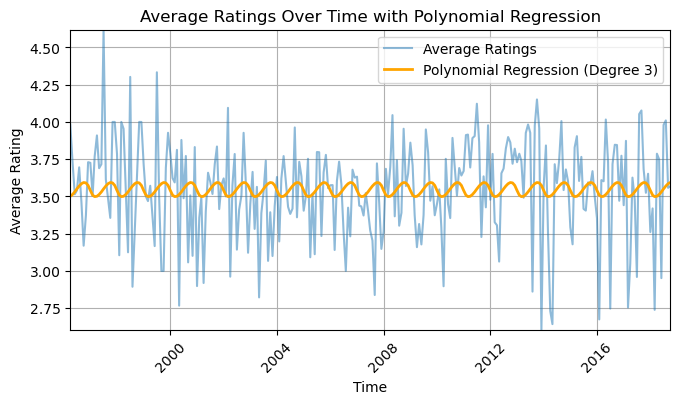

In [108]:
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit="s")
ratings.set_index("timestamp", inplace=True)
average_ratings_over_time = ratings.resample("M")["rating"].mean().reset_index()

# Handle missing values by interpolating
average_ratings_over_time["rating"].interpolate(method="linear", inplace=True)

# Extract the numeric month from the timestamp
average_ratings_over_time["month_numeric"] = average_ratings_over_time[
    "timestamp"
].dt.month

# Perform polynomial regression
X = average_ratings_over_time["month_numeric"].values.reshape(-1, 1)
y = average_ratings_over_time["rating"].values

degree = 3
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X, y)
y_pred = model.predict(X)

plt.figure(figsize=(6, 3))
sns.lineplot(
    data=average_ratings_over_time,
    x="timestamp",
    y="rating",
    label="Average Ratings",
    alpha=0.5,
)
plt.plot(
    average_ratings_over_time["timestamp"],
    y_pred,
    label=f"Polynomial Regression (Degree {degree})",
    linewidth=2,
    color="orange",
)
plt.title("Average Ratings Over Time with Polynomial Regression")
plt.xlabel("Time")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig("../reports/assets/arot_regressed.png", bbox_inches="tight")

In [109]:
ratings = ratings_backup.copy()

In [110]:
missing_values_count = ratings.isna().sum().sum()
print(f"There are {missing_values_count} missing values in the ratings DataFrame.")

There are 0 missing values in the ratings DataFrame.


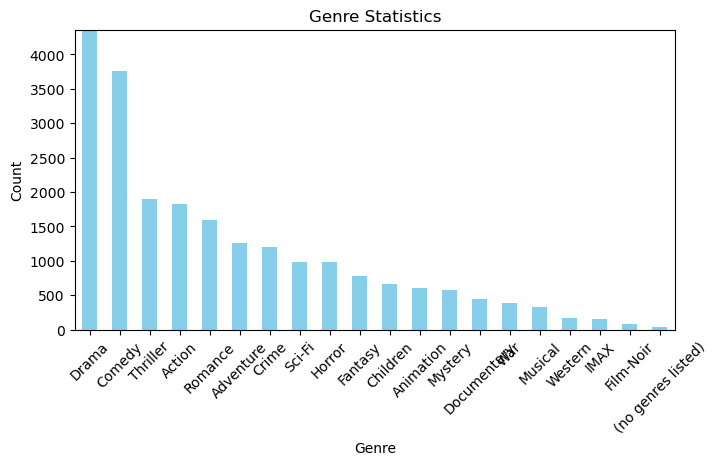

In [115]:
movies["genre_list"] = movies["genres"].str.split("|")

# Create a flat list of genres
all_genres = [genre for sublist in movies["genre_list"] for genre in sublist]

# Count the occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()
movies.drop(columns=["genre_list"], inplace=True)
# Plot genre statistics
plt.figure(figsize=(6, 3))
genre_counts.plot(kind="bar", color="skyblue")
plt.title("Genre Statistics")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig("../reports/assets/genre_distribution.png", bbox_inches="tight")

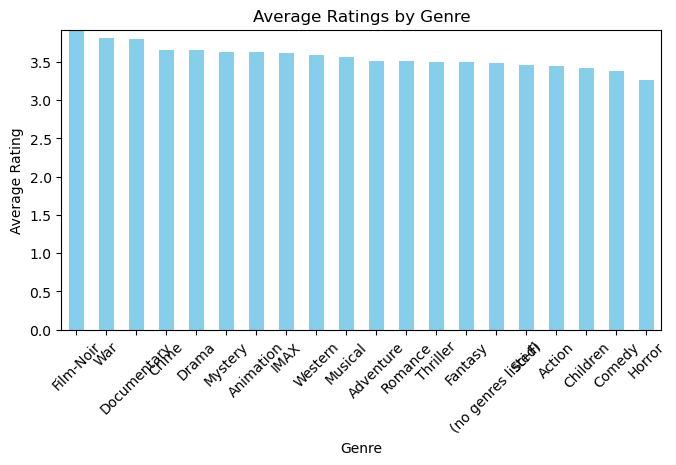

In [116]:
combined_data = pd.merge(ratings, movies, on="movieId")

# Split genres into a list of genres
combined_data["genre_list"] = combined_data["genres"].str.split("|")

# Explode the 'genre_list' column into separate rows
combined_data = combined_data.explode("genre_list")

# Calculate the average rating for each genre
genre_avg_ratings = combined_data.groupby("genre_list")["rating"].mean()

# Plot the average ratings
plt.figure(figsize=(6, 3))
genre_avg_ratings.sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("Average Ratings by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig("../reports/assets/genre_rating.png", bbox_inches="tight")

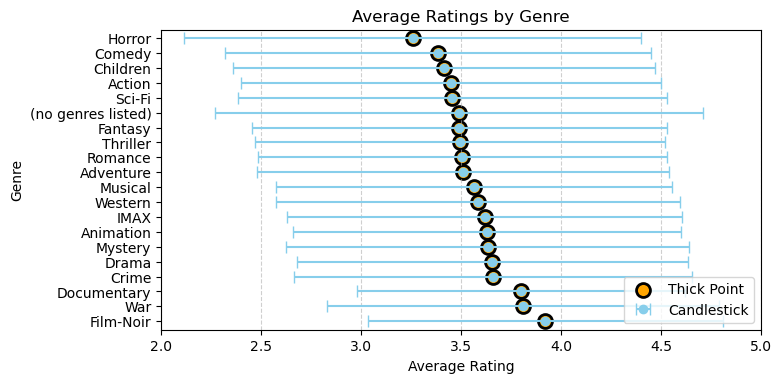

In [125]:
# Merge the 'movies' and 'ratings' DataFrames on 'movieId'
combined_data = pd.merge(ratings, movies, on="movieId")

# Split genres into a list of genres
combined_data["genre_list"] = combined_data["genres"].str.split("|")

# Explode the 'genre_list' column into separate rows
combined_data = combined_data.explode("genre_list")

# Calculate the average rating and rating range for each genre
genre_avg_ratings = combined_data.groupby("genre_list")["rating"].agg(["mean", "std"])

# Sort genres by average rating
genre_avg_ratings.sort_values(by="mean", ascending=False, inplace=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 3))

# Plot candlesticks (vertical lines with error bars)
ax.errorbar(
    genre_avg_ratings["mean"],
    genre_avg_ratings.index,
    xerr=genre_avg_ratings["std"],
    fmt="o",
    color="skyblue",
    capsize=4,
    label="Candlestick",
)

# Plot thick points for average ratings
ax.scatter(
    genre_avg_ratings["mean"],
    genre_avg_ratings.index,
    color="orange",
    s=100,
    marker="o",
    edgecolors="black",
    linewidths=2,
    label="Thick Point",
)

# Set the x-axis limits to match the rating scale
ax.set_xlim(2, 5)

# Customize labels and legend
ax.set_title("Average Ratings by Genre")
ax.set_xlabel("Average Rating")
ax.set_ylabel("Genre")
ax.grid(axis="x", linestyle="--", alpha=0.6)
ax.legend(loc="lower right")

plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0.03)
plt.savefig("../reports/assets/genre_candle_rating.png", bbox_inches="tight")

/var/folders/rp/ggplbw_d5p97pwq5_00q6jdm0000gn/T/ipykernel_4793/3218550075.py:6: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  pd.get_dummies(movies["genre_list"].apply(pd.Series).stack()).groupby(level=0).sum()


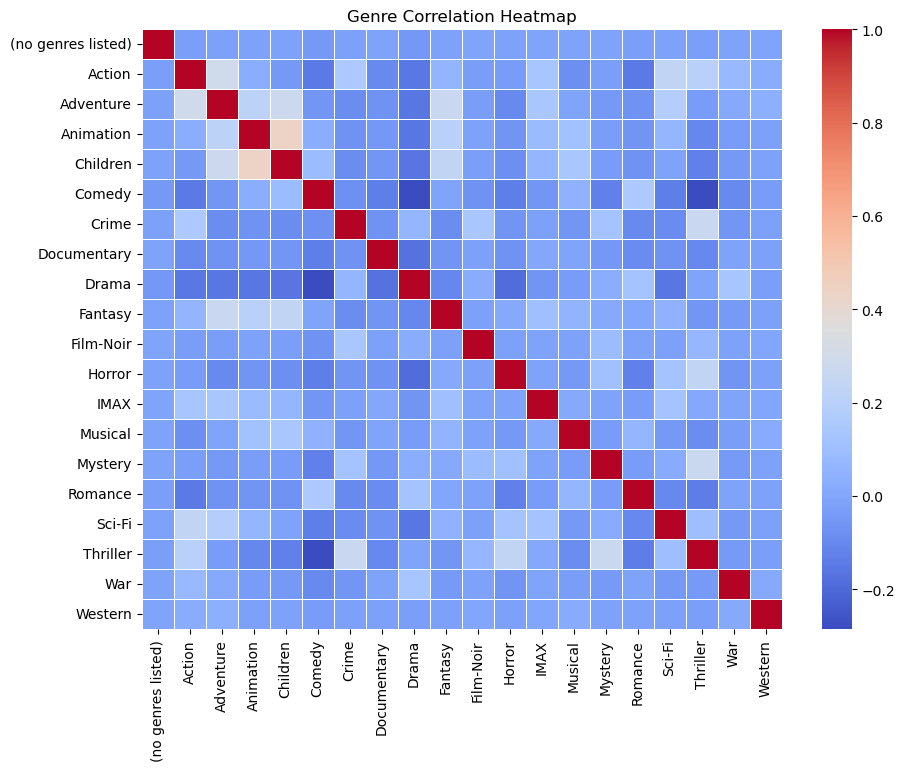

In [122]:
# Split genres into a list of genres using the apply function
movies["genre_list"] = movies["genres"].apply(lambda x: x.split("|"))

# Create a binary genre matrix
binary_genre_matrix = (
    pd.get_dummies(movies["genre_list"].apply(pd.Series).stack()).groupby(level=0).sum()
)

# Calculate the correlation matrix between binary genre columns
genre_correlation_matrix = binary_genre_matrix.corr()

# Increase plot dimensions
plt.figure(figsize=(8, 6))

# Create a heatmap to visualize the genre correlations
sns.heatmap(genre_correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Genre Correlation Heatmap")
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig("../reports/assets/genre_corr_heatmap.png", bbox_inches="tight")